Paper: https://arxiv.org/abs/2003.00295

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.ops import MLP
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100, CIFAR10, MNIST
from torch.optim import SGD, lr_scheduler
import copy
from tqdm import tqdm
from collections import OrderedDict
import random
import math
import matplotlib.pyplot as plt
from client_selector import ClientSelector

## Data

In [2]:
K = 100

params = {
    'K': K,
    'C': 0.1,
    'B': 20,
    'J': 4,
    'lr_server': 1e-1,
    'lr_client': 1e-1,
    'method': 'fedavg',
    'beta1': 0,
    'beta2': 0,
    'tau': 1e-3,
    'gamma': 0.0001,
    'participation': 'uniform'
}

In [3]:
preprocess = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = CIFAR10('datasets/cifar10', train=True, transform=preprocess, download=True)
test_dataset = CIFAR10('datasets/cifar10', train=False, transform=preprocess, download=True)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12776068.64it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


In [4]:
iid = True
samples_per_client = int(len(train_dataset) / K)
shards_per_client = 2

def split_data(dataset, iid=True):
    if iid:
        return torch.utils.data.random_split(train_dataset, [samples_per_client] * K)
    else:
        sorted_dataset = sorted(train_dataset, key=lambda x: x[1])
        shard_size = int(samples_per_client / shards_per_client)
        shards = [
            torch.utils.data.Subset(
                sorted_dataset,
                range(i*shard_size, (i+1)*shard_size)
            )
            for i in range(K*shards_per_client)
        ]

        random.shuffle(shards)

        return [
            torch.utils.data.ConcatDataset([shards[2*i], shards[2*i+1]])
            for i in range(K)
        ]


client_datasets = split_data(train_dataset, iid)
assert len(client_datasets) == K
assert len(client_datasets[0]) == samples_per_client
assert iid or all([0 < len(set(map(lambda x: x[1], client_datasets[i]))) <= 4 for i in range(K)])

In [6]:
client_selector = ClientSelector(params)

## Model

In [7]:
class LeNet5_circa(nn.Module):
    def __init__(self):
        super( LeNet5_circa, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(576, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x).relu())
        x = self.pool(self.conv2(x).relu())
        x = torch.flatten(x, 1)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        x = nn.functional.softmax(x)
        return x


model = LeNet5_circa().cuda()
model.to('cuda')

criterion = torch.nn.CrossEntropyLoss().cuda()

In [8]:
model

LeNet5_circa(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=10, bias=True)
)

## Utils

In [9]:
def reduce_w(w_list, f):
    return OrderedDict([
            (key, f([x[key] for x in w_list])) for key in w_list[0].keys()
        ])


def tensor_sum(tensors_list):
    return torch.sum(torch.stack(tensors_list), dim=0)


def w_norm2(w):
    res = 0
    for key in w.keys():
        res += torch.linalg.vector_norm(w[key]) ** 2
    return math.sqrt(res)


def fed_adagrad(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return v + delta_norm2


def fed_yogi(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return v - (1-params['beta2']) * delta_norm2 * torch.sign(v - delta_norm2)


def fed_adam(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return params['beta2'] * v + (1-params['beta2']) * delta_norm2


methods = {
    'adagrad': fed_adagrad,
    'yogi': fed_yogi,
    'adam': fed_adam
}

## Training

In [10]:
T = 100
test_freq = 10

In [11]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy


def client_update(model, k, params):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=params['lr_client'])
    loader = DataLoader(client_datasets[k], batch_size=params['B'])

    for i in range(params['J']):
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    return model.state_dict()


def train(model, params):
    accuracies = []
    v = params['tau'] ** 2
    w = model.state_dict()
    m = reduce_w([w], lambda x: torch.mul(x[0], 0.0))
    for t in tqdm(range(T)):
        s = client_selector.sample()

        w_clients = []
        for k in s:
            w_clients.append(client_update(copy.deepcopy(model), k, params))

        if params['method'] == 'fedavg':
            w = reduce_w(
                w_clients,
                lambda x: tensor_sum(x) / len(w_clients)
            )
        else:
            deltas = [
                reduce_w(
                    [w, w_client],
                    lambda x: x[1] - x[0]
                ) for w_client in w_clients
            ]

            # n_weights = [len(client_datasets[k])/len(w_clients) for k in s]
            delta = reduce_w(
                deltas,
                lambda x: tensor_sum(x) / len(deltas)
            )

            m = reduce_w(
                [m, delta],
                lambda x: params['beta1'] * x[0] + (1-params['beta1']) * x[1]
            )

            v = methods[params['method']](v, delta, params)
            w = reduce_w(
                [w, m],
                lambda x: x[0] + params['lr_server'] * x[1] / (math.sqrt(v) + params['tau'])
            )

        model.load_state_dict(w)

        if t % test_freq == 0 or t == T-1:
            accuracies.append(test(model))

    return accuracies


accuracies = train(model, params)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-7-6e4b5e5ef2b3>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)
  1%|          | 1/100 [00:13<23:00, 13.95s/it]

Test Loss: 2.302016 Acc: 10.00%


 11%|█         | 11/100 [01:54<16:18, 10.99s/it]

Test Loss: 2.155343 Acc: 29.16%


 21%|██        | 21/100 [03:37<14:27, 10.99s/it]

Test Loss: 2.099692 Acc: 35.28%


 31%|███       | 31/100 [05:17<12:26, 10.82s/it]

Test Loss: 2.066805 Acc: 38.60%


 41%|████      | 41/100 [06:58<10:38, 10.82s/it]

Test Loss: 2.037717 Acc: 41.71%


 51%|█████     | 51/100 [08:45<09:06, 11.14s/it]

Test Loss: 2.019099 Acc: 43.86%


 61%|██████    | 61/100 [10:26<07:02, 10.83s/it]

Test Loss: 2.000682 Acc: 45.89%


 71%|███████   | 71/100 [12:06<05:12, 10.78s/it]

Test Loss: 1.978280 Acc: 47.81%


 81%|████████  | 81/100 [13:47<03:26, 10.84s/it]

Test Loss: 1.968884 Acc: 49.18%


 91%|█████████ | 91/100 [15:26<01:37, 10.82s/it]

Test Loss: 1.951646 Acc: 50.56%


100%|██████████| 100/100 [16:57<00:00, 10.17s/it]

Test Loss: 1.936725 Acc: 52.43%


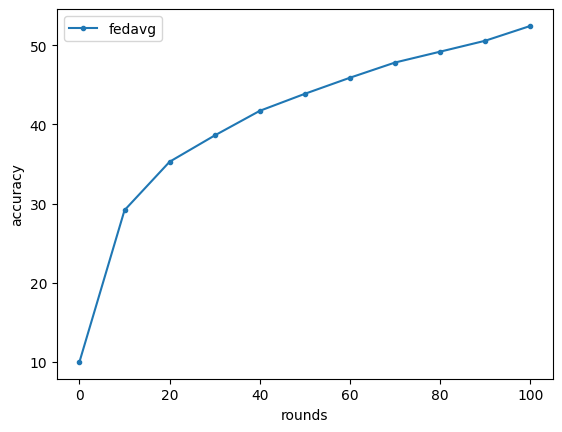

In [12]:
plt.xlabel('rounds')
plt.ylabel('accuracy')
xx = np.arange(0, T + test_freq, test_freq)
plt.plot(xx, accuracies, label=params['method'], marker='.')
plt.legend()